# Kinetics Kalculator

### First, we define the relevant paths that we will use

In [2]:
# Editable install the package in the current python environment (we suggest installing within a conda environment)
import sys

!{sys.executable} -m pip install -e ../

Obtaining file:///Users/nathanielcorley/Projects/kinetics-kalculator
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached pandas-2.2.3-cp313-cp313-macosx_10_13_x86_64.whl.metadata (89 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached scipy-1.14.1-cp313-cp313-macosx_10_13_x86_64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.3 MB

In [1]:
# Set the path to the root of the directory
import os

os.chdir("../")

import pandas as pd
from pathlib import Path
from kinetics_kalculator.kinetics_kalculator import KineticsKalculator

In [19]:
kinetics_data_path = Path("examples/EX_kinetics_data.csv")
standard_curves_path = Path("examples/EX_standard_curves.json")

assert kinetics_data_path.exists(), f"File not found: {kinetics_data_path}"
assert standard_curves_path.exists(), f"File not found: {standard_curves_path}"

### Load the standard curves into a dictionary

In [20]:
# Load standard curves JSON into a dictionary
all_standard_curves = pd.read_json(standard_curves_path, typ="series").to_dict()
experiment_specific_standard_curve = all_standard_curves[21062324]["mscarlett"]

### Initialize the `KineticsKalculator` object

In [21]:
kalculator = KineticsKalculator(
    data_path=kinetics_data_path,
    standard_curve_parameters=experiment_specific_standard_curve,
)

### Take a look at the default data

In [22]:
kalculator.data.head()

,Unnamed: 0,time,well,value,serial_number,plate_number,sample_number,row,column,replicate_number,name,substrate_concentration,enzyme_concentration,sample_type
0,0,6,I1,314.0,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample
1,1,26,I1,320.0,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample
2,2,46,I1,328.0,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample
3,3,66,I1,331.0,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample
4,4,86,I1,337.0,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample


### Label replicates and conditions

In [23]:
kalculator.label_replicates_and_conditions(
    condition_columns=["substrate_concentration", "enzyme_concentration"]
)

### Conver the "value" column, which is an absorbance measurement, to the appropriate "concentration" measurement

In [24]:
# Convert the "value" (which is an absorbance) to "concentration" using the standard curve
kalculator.convert_values_to_concentration_with_standard_curve()

In [25]:
# ...and visualize, now our "value" column is in the correct concentration, adjusting for the standard curve!
kalculator.data.head()

,Unnamed: 0,time,well,value,serial_number,plate_number,sample_number,row,column,replicate_number,name,substrate_concentration,enzyme_concentration,sample_type,condition,replicate_n
0,0,6,I1,0.300911,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",1
1,1,26,I1,0.306789,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",2
2,2,46,I1,0.314626,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",3
3,3,66,I1,0.317565,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",4
4,4,86,I1,0.323442,21062324,1,1,I,1,1,dad_t1_cys,100.0,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",5


### Visualize concentration vs. time for different conditions

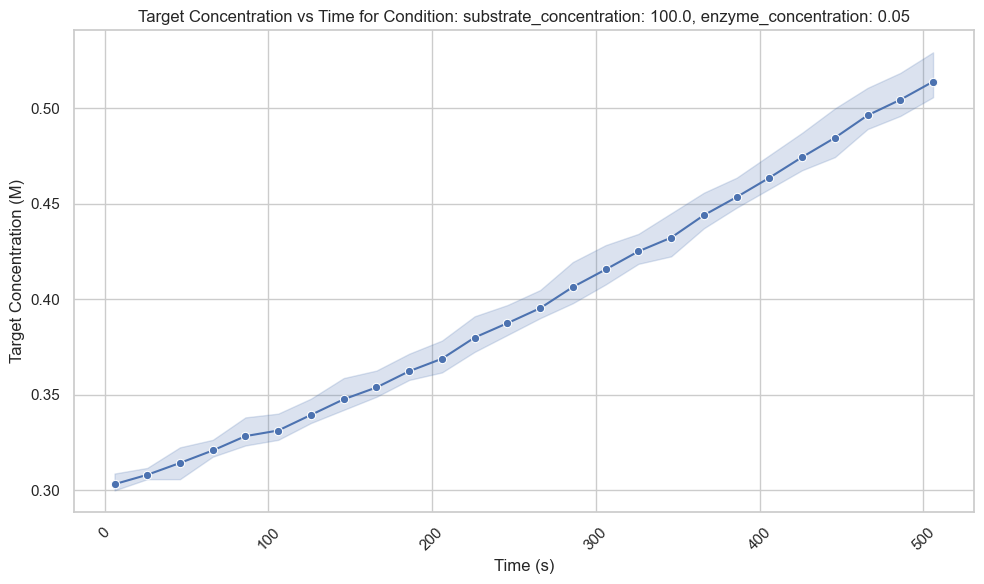

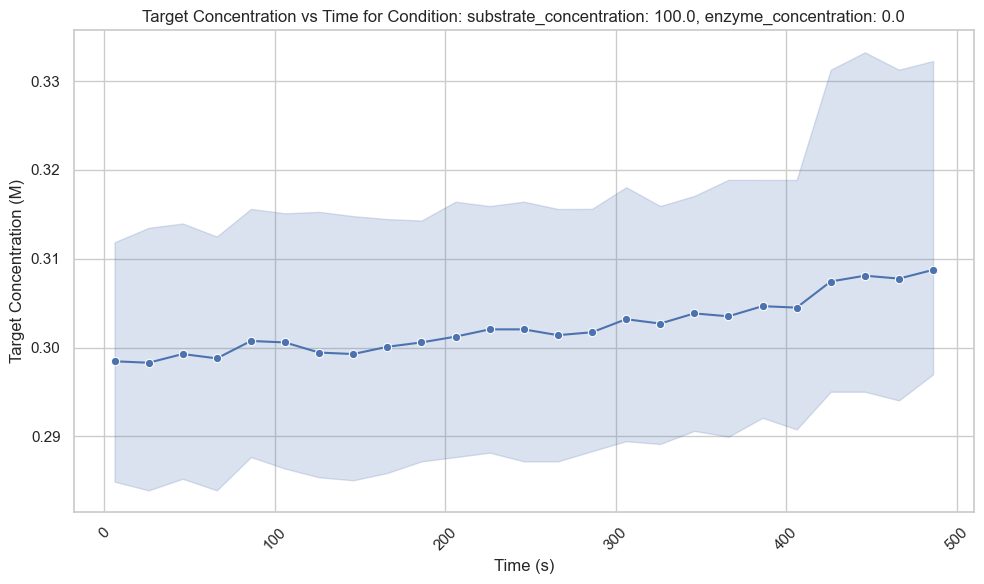

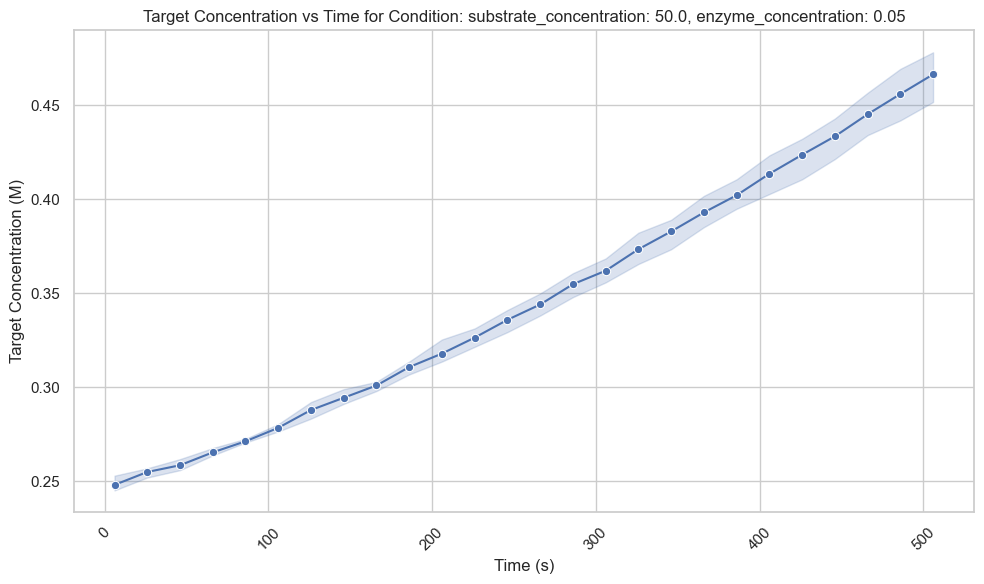

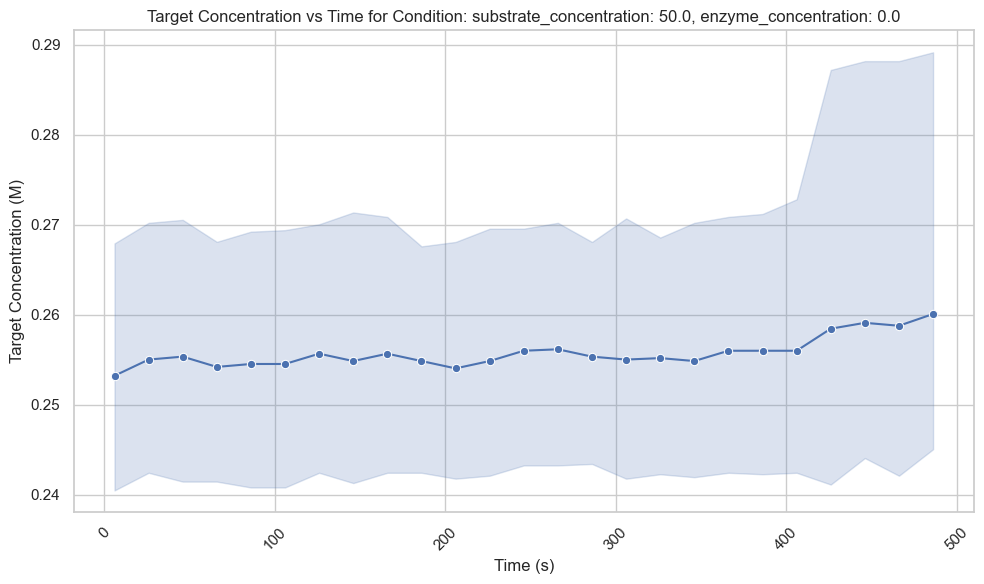

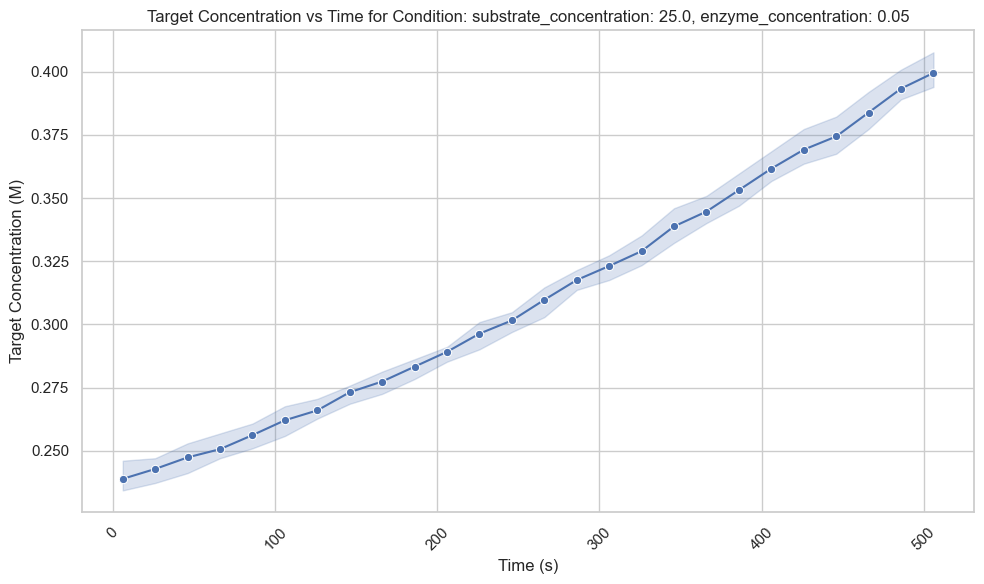

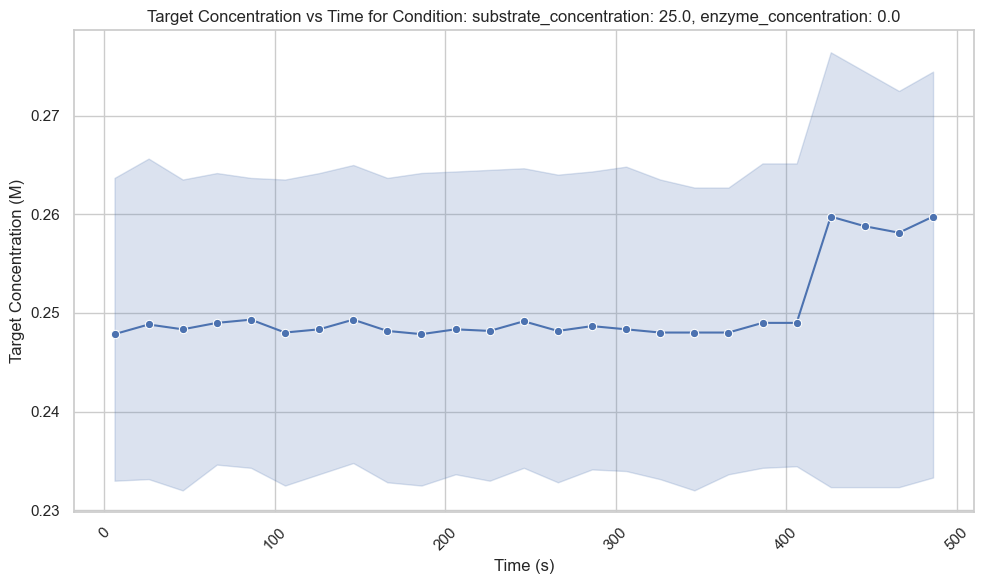

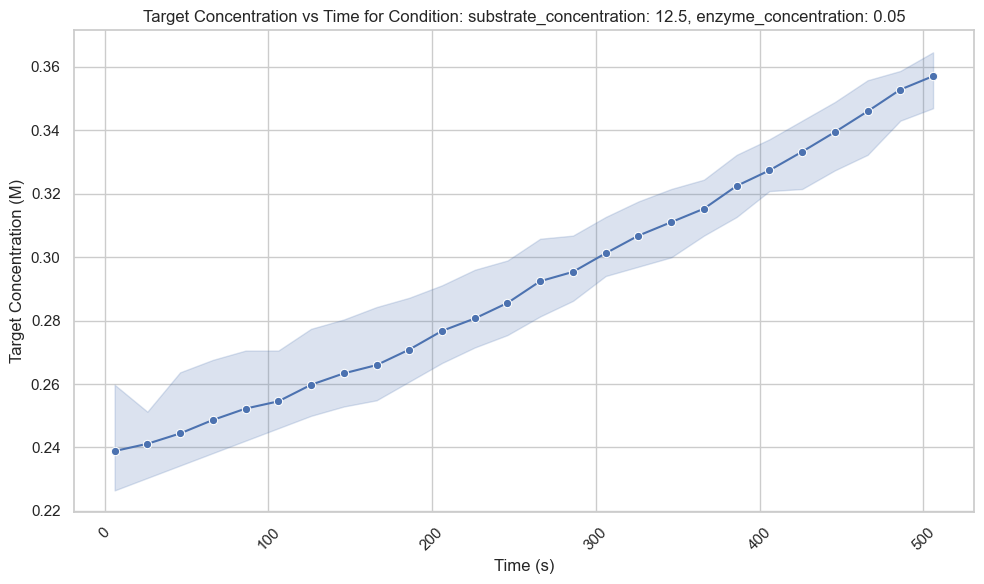

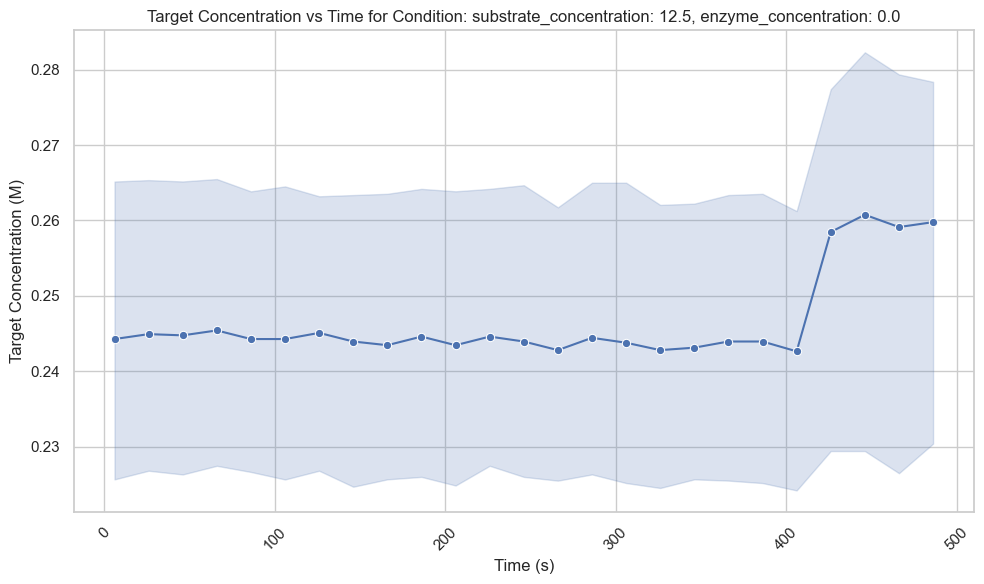

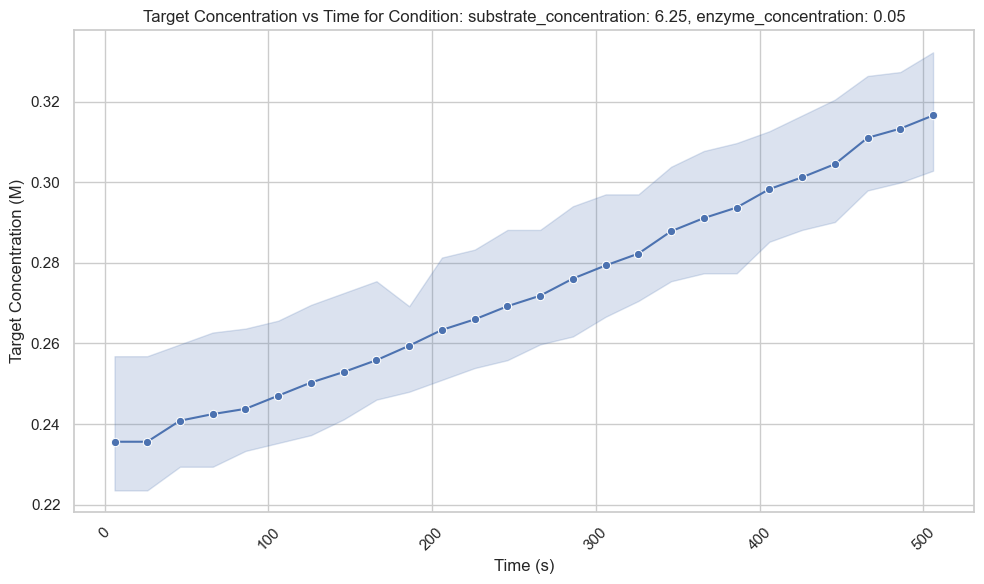

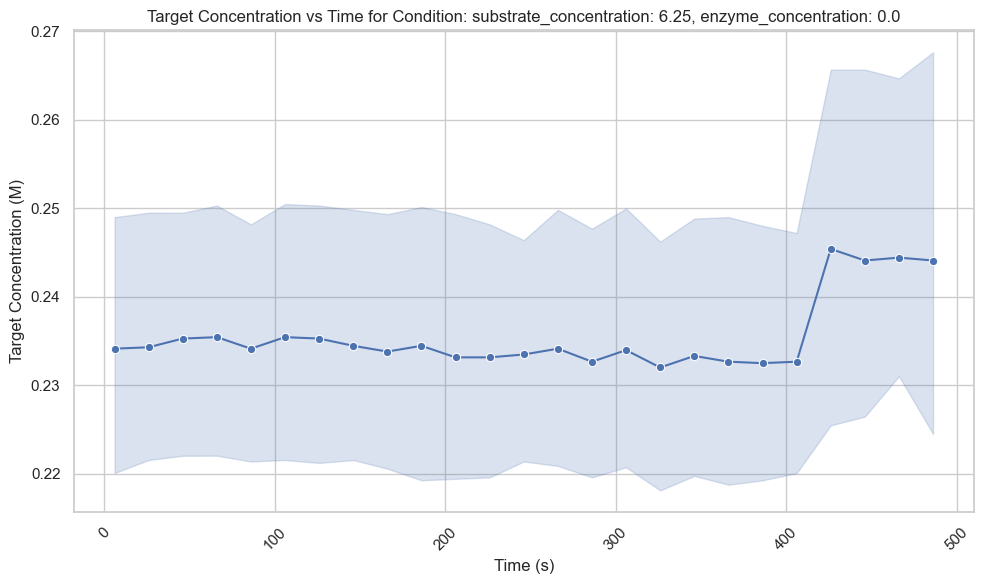

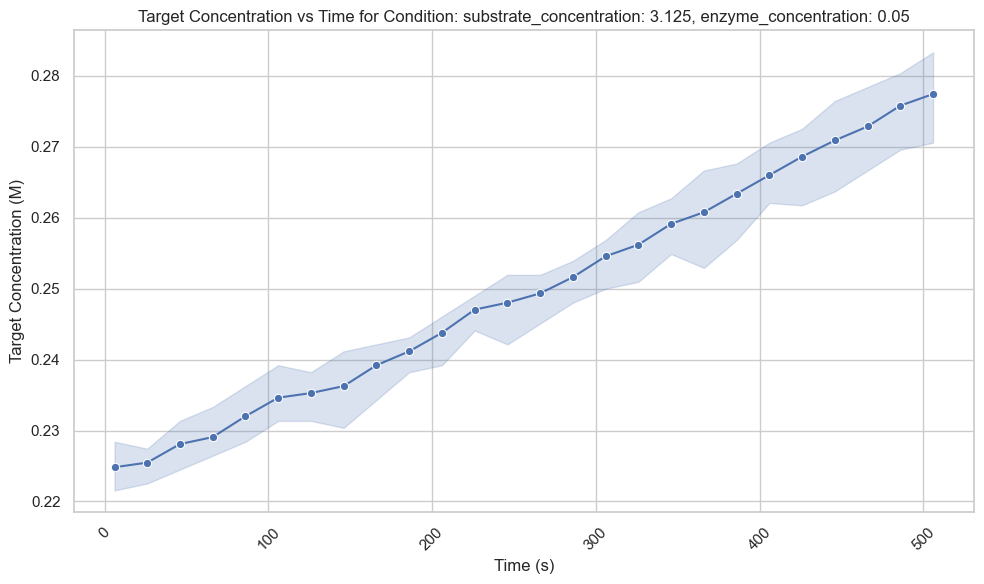

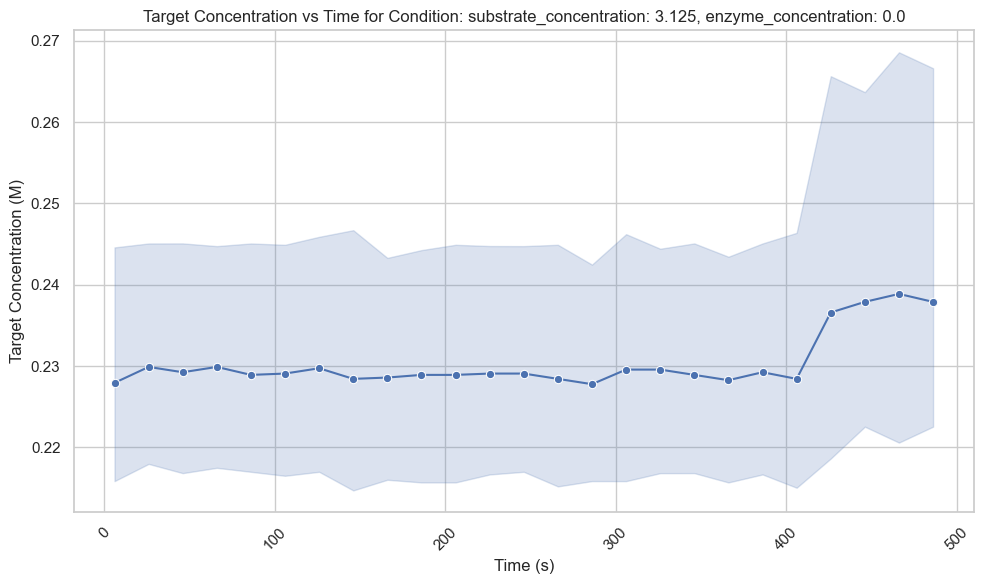

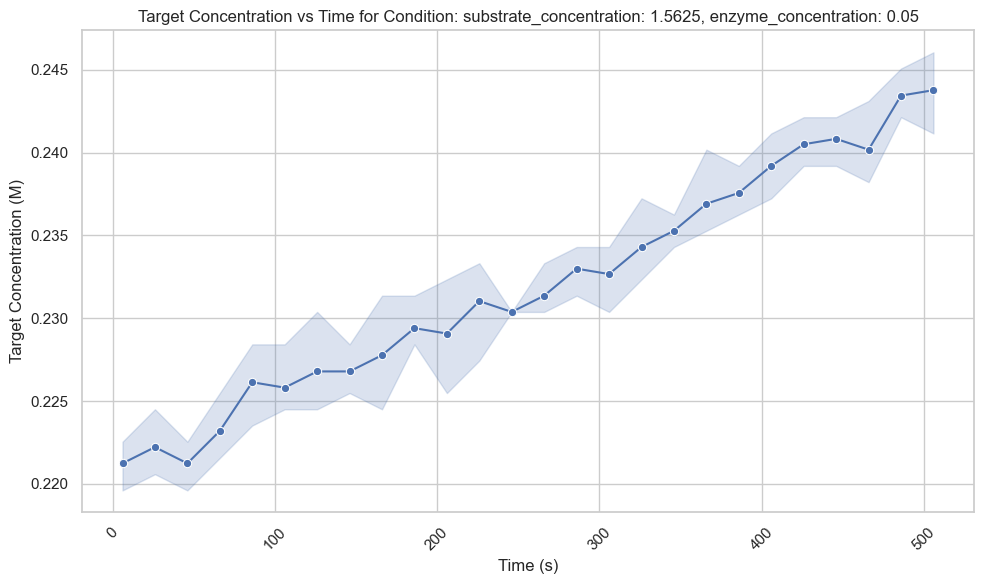

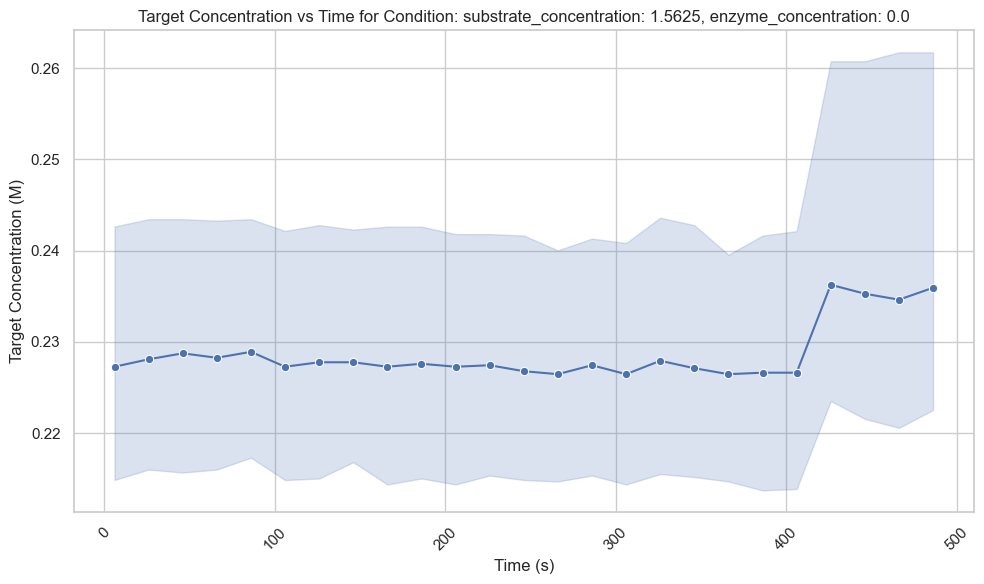

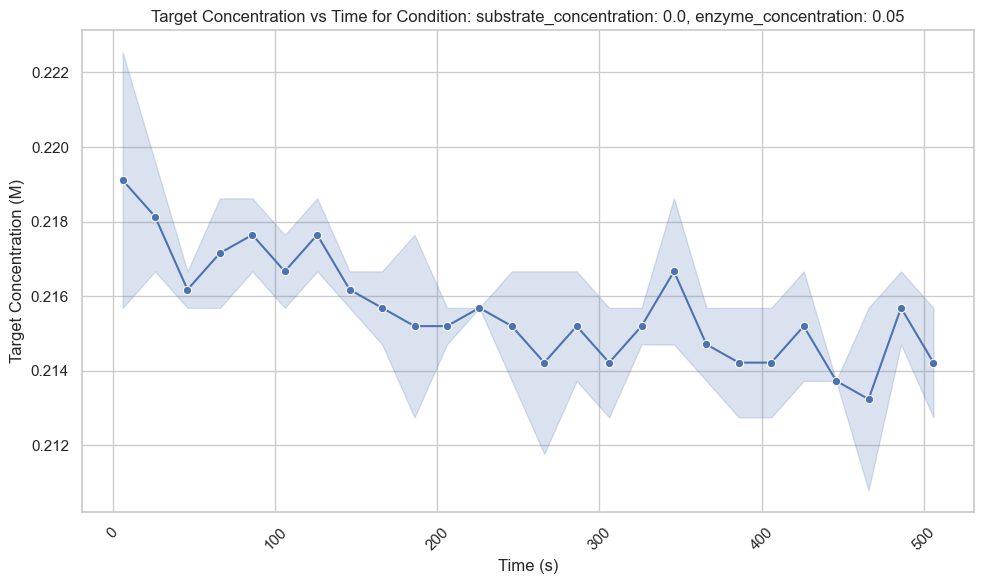

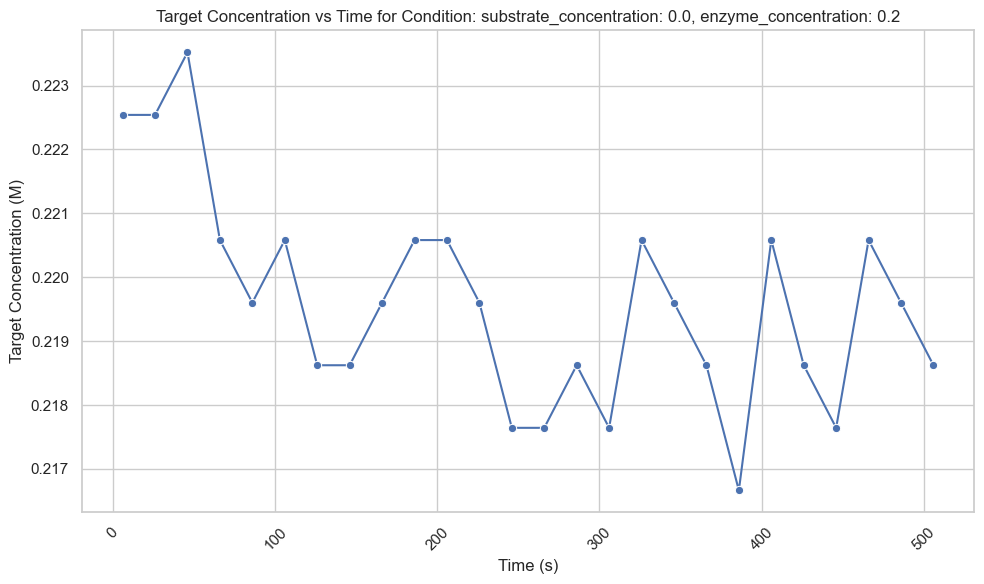

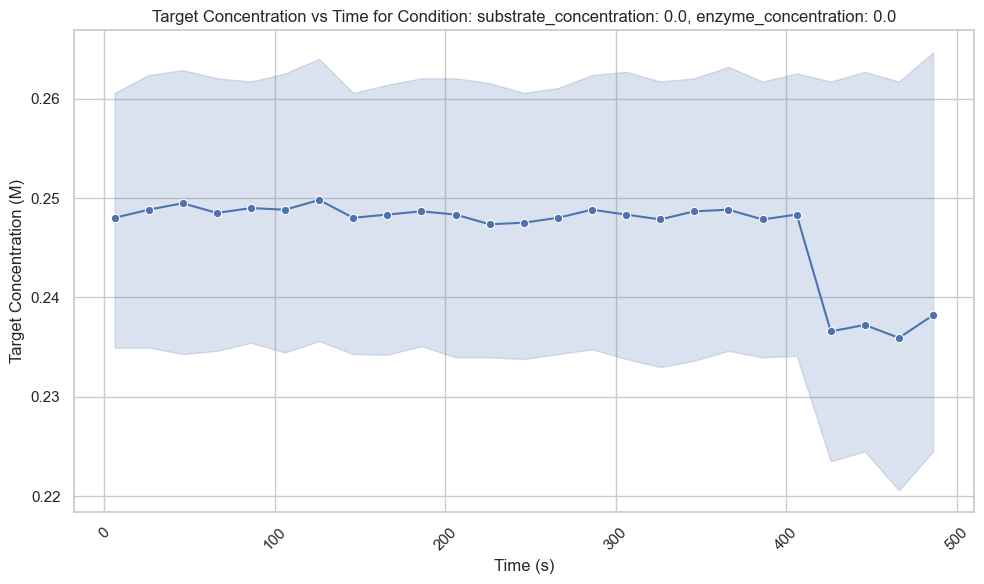

In [26]:
kalculator.plot_concentration_vs_time_for_each_condition()

Based off this graph, it seems like a time range of 100-400 seconds seems the most appropriate to avoid noise

### Filter to time range

In [27]:
kalculator.subset_dataframe_to_time_range(100, 400)

### Calculate rates

In [28]:
kalculator.calculate_rates(
    time_column="time",
    value_column="value",
    group_by_columns=["condition"],
    print_fit_summary=True,
)

Name: 1, dtype: object with r^2 = 0.12
Name: 2, dtype: object with r^2 = 0.17


                                             Rates of Change by Group                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                          condition ┃      rate ┃ intercept ┃   r_value ┃  p_value ┃  std_err ┃      sample_type ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│      substrate_concentration: 0.0, │ -0.000002 │  0.248822 │ -0.009257 │ 0.930995 │ 0.000022 │ negative_control │
│          enzyme_concentration: 0.0 │           │           │           │          │          │                  │
│      substrate_concentration: 0.0, │ -0.000007 │  0.217155 │ -0.353139 │ 0.055592 │ 0.000003 │           sample │
│         enzyme_concentration: 0.05 │           │           │           │          │          │                  │
│      substrate_concentration: 0.0, │ -0.000006 │  0.220478 │ -0.418258 │ 0.120780 │ 0.000004 │           sample │
│          enzyme_concentration: 0.2 │           │           │           │          │          │                  │
│   substrate_concentration: 1.5625, │ -0.000003 │  0.227931 │ -0.015364 │ 0.885717 │ 0.000021 │ negative_control │
│          enzyme_concentration: 0.0 │           │           │           │          │          │                  │
│   substrate_concentration: 1.5625, │  0.000041 │  0.221121 │  0.873036 │ 0.000000 │ 0.000003 │           sample │
│         enzyme_concentration: 0.05 │           │           │           │          │          │                  │
│    substrate_concentration: 100.0, │  0.000017 │  0.297607 │  0.081192 │ 0.446808 │ 0.000022 │ negative_control │
│          enzyme_concentration: 0.0 │           │           │           │          │          │                  │
│    substrate_concentration: 100.0, │  0.000436 │  0.282323 │  0.979393 │ 0.000000 │ 0.000014 │           sample │
│         enzyme_concentration: 0.05 │           │           │           │          │          │                  │
│     substrate_concentration: 12.5, │ -0.000003 │  0.244660 │ -0.011737 │ 0.912574 │ 0.000029 │ negative_control │
│          enzyme_concentration: 0.0 │           │           │           │          │          │                  │
│     substrate_concentration: 12.5, │  0.000241 │  0.227490 │  0.895889 │ 0.000000 │ 0.000018 │           sample │
│         enzyme_concentration: 0.05 │           │           │           │          │          │                  │
│     substrate_concentration: 25.0, │ -0.000000 │  0.248378 │ -0.000127 │ 0.999052 │ 0.000024 │ negative_control │
│          enzyme_concentration: 0.0 │           │           │           │          │          │                  │
│     substrate_concentration: 25.0, │  0.000328 │  0.223756 │  0.986937 │ 0.000000 │ 0.000008 │           sample │
│         enzyme_concentration: 0.05 │           │           │           │          │          │                  │
│    substrate_concentration: 3.125, │ -0.000000 │  0.228998 │ -0.001930 │ 0.985596 │ 0.000023 │ negative_control │
│          enzyme_concentration: 0.0 │           │           │           │          │          │                  │
│    substrate_concentration: 3.125, │  0.000106 │  0.221904 │  0.927895 │ 0.000000 │ 0.000007 │           sample │
│         enzyme_concentration: 0.05 │           │           │           │          │          │                  │
│     substrate_concentration: 50.0, │  0.000003 │  0.254637 │  0.012526 │ 0.906719 │ 0.000022 │ negative_control │
│          enzyme_concentration: 0.0 │           │           │           │          │          │                  │
│     substrate_concentration: 50.0, │  0.000442 │  0.228919 │  0.990423 │ 0.000000 │ 0.000009 │           sample │
│         enzyme_concentration: 0.05 │           │           │           │          │          │                  │
│     substrate_concentration: 6.25, │ -0.000009 │  0.23

### Adjust for background rates

In [29]:
# By default, we look for the "negative-control" column in the dataframe
kalculator.adjust_rates_for_background(
    rate_column="rate",
    sample_type_column="sample_type",
    negative_control="negative_control",
)

In [30]:
kalculator.data.head()

,Unnamed: 0,time,well,value,serial_number,plate_number,sample_number,row,column,replicate_number,...,enzyme_concentration,sample_type,condition,replicate_n,rate,intercept,r_value,p_value,std_err,rate_minus_background
0,5,106,I1,0.328341,21062324,1,1,I,1,1,...,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",6,0.000436,0.282323,0.979393,1.651579e-31,0.000014,0.000435
1,6,126,I1,0.335198,21062324,1,1,I,1,1,...,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",7,0.000436,0.282323,0.979393,1.651579e-31,0.000014,0.000435
2,7,146,I1,0.342055,21062324,1,1,I,1,1,...,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",8,0.000436,0.282323,0.979393,1.651579e-31,0.000014,0.000435
3,8,166,I1,0.349892,21062324,1,1,I,1,1,...,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",9,0.000436,0.282323,0.979393,1.651579e-31,0.000014,0.000435
4,9,186,I1,0.357729,21062324,1,1,I,1,1,...,0.05,sample,"substrate_concentration: 100.0, enzyme_concent...",10,0.000436,0.282323,0.979393,1.651579e-31,0.000014,0.000435


### Calculate Michaelis Menten constants, using SciPy to determine the optimal parameter values

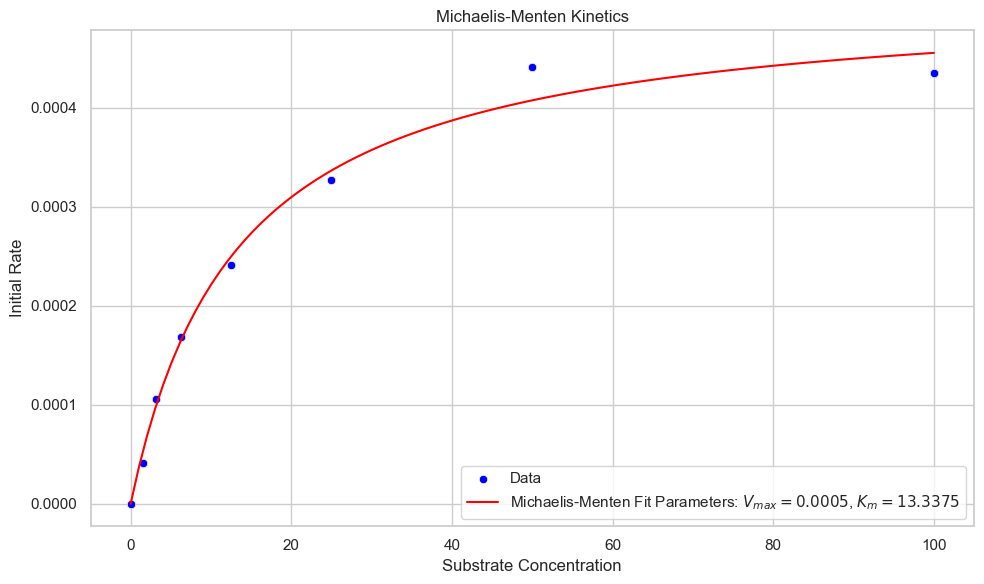

In [32]:
kalculator.plot_michaelis_menten_curve()